In [1]:
import sys
import os
from ml4cvd.arguments import parse_args
from ml4cvd.recipes import run
import h5py
import numpy as np
import matplotlib.pyplot as plt
from typing import List, Dict, Callable
from collections import defaultdict
import pandas as pd

from ml4cvd.arguments import _get_tmap
from ml4cvd.TensorMap import TensorMap
from ml4cvd.tensor_from_file import TMAPS

import numpy as np
USER = 'pdiachil'
HOME_PATH = '/home/' + USER

/usr/local/lib/python3.6/dist-packages/apache_beam/__init__.py:84: UserWarning: Running the Apache Beam SDK on Python 3 is not yet fully supported. You may encounter buggy behavior or missing features.
  'Running the Apache Beam SDK on Python 3 is not yet fully supported. '
Using TensorFlow backend.


In [2]:
# sys.argv = ['tensorize',
#             '--mode', 'tensorize_ludb',
#             '--xml_folder', f'{HOME_PATH}/ludb/',
#             '--output_folder', f'{HOME_PATH}/ludb_tensors/',
#             '--tensors', f'{HOME_PATH}/ludb_tensors/',
#             '--min_sample_id', '1', 
#             '--max_sample_id', '201'
#            ]
# args = parse_args()
# run(args)

['electric axis of the heart: left axis deviation left ventricular hypertrophy left ventricular overload non-specific repolarization abnormalities: posterior wall']


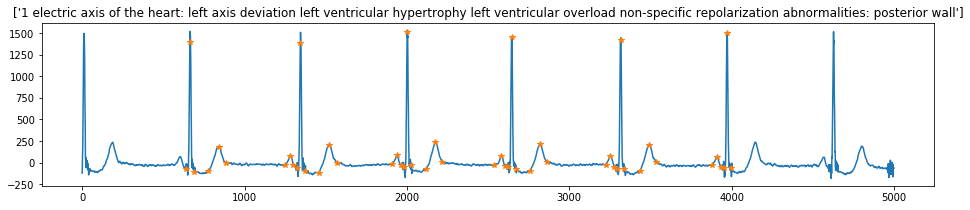

In [3]:
%matplotlib inline
for i in range(1, 200):
    with h5py.File(f'{HOME_PATH}/ludb_tensors/{i}.hd5', 'r') as hd5:
        f, ax = plt.subplots()
        f.set_size_inches(16, 3)
        ann = np.array(hd5['ecg_rest_annotation/annotation_i'])
        data = np.array(hd5['ecg_rest/strip_i'])
        ax.plot(data)
        ax.plot(ann, data[ann], '*')
        print(hd5['ecg_rest_text'][()])
        ax.set_title(str(i) + ' ' + hd5['ecg_rest_text'][()])
    break

In [4]:
def annotation_to_segmentation(data, ann, shape = (5000,)):
    cycle = ['QR', 'RS', 'ST1', 'T1T2', 'T2T3', 'T3P1', 'P1P2', 'P2P3', 'P3Q']
    parsed_data = np.zeros(shape)
    parsed_range = ann[-1] - ann[0]
    parsed_data[:parsed_range] = data[ann[0]:ann[-1]]
    segmented_data = np.zeros(shape, dtype=np.int)
    ic = 0
    for ia in range(len(ann)-1):
        segmented_data[ann[ia]-ann[0]:ann[ia+1]-ann[0]] = ic
        ic += 1
        if ic == len(cycle):
            ic = 0
    return parsed_data, segmented_data      

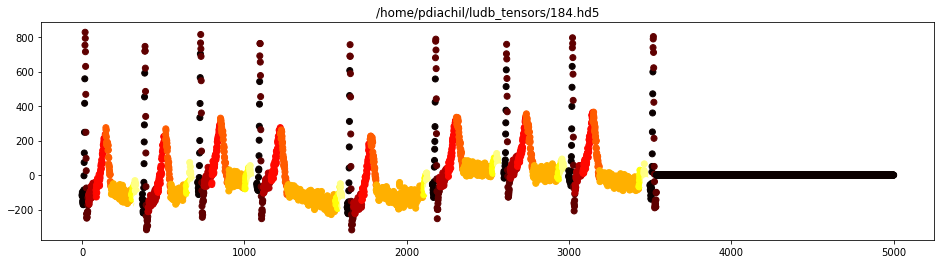

In [5]:
import glob
from matplotlib import cm
hd5_paths = glob.glob(f'{HOME_PATH}/ludb_tensors/*.hd5')
for hd5_path in hd5_paths:
    with h5py.File(hd5_path, 'r') as hd5:        
        ann = np.array(hd5['ecg_rest_annotation/annotation_i'])
        data = np.array(hd5['ecg_rest/strip_i'])
        parsed, segmented = annotation_to_segmentation(data, ann)
        f, ax = plt.subplots()
        f.set_size_inches(16, 4)
        ax.scatter(range(len(parsed)), parsed, c=cm.hot(segmented/8.0))
        ax.set_title(hd5_path)
        
    break

In [6]:
import glob
from ml4cvd.arguments import _get_tmap
hd5_paths = glob.glob(f'{HOME_PATH}/ludb_tensors/*.hd5')
tm_data = _get_tmap('ecg_rest_ludb')
tm_segmentation = _get_tmap('ecg_rest_ludb_segmentation_weighted')
for hd5_path in hd5_paths:
    with h5py.File(hd5_path, 'r') as hd5:
        data = tm_data.tensor_from_file(tm_data, hd5)
        segmentation = tm_segmentation.tensor_from_file(tm_segmentation, hd5)
    break

In [7]:
# sys.argv = ['train',
#             '--mode', 'train',
#             '--output_folder', f'{HOME_PATH}/ludb_output/',
#             '--tensors', f'{HOME_PATH}/ludb_tensors/',
#             '--input_tensors', 'ecg_rest_ludb',
#             '--output_tensors', 'ecg_rest_ludb_segmentation',
#             '--id', 'test_ludb_segmentation',
#             '--num_workers', '0',
#             '--inspect_model',
#             '--training_steps', '14',
#             '--validation_steps', '2',
#             '--test_steps', '2',
#             '--batch_size', '4',
#             '--epochs', '100'
#            ]
# args = parse_args()
# run(args)

In [8]:
def tmaps_by_sample_id(tensor_folder: str, sample_id: str, tmaps: List[TensorMap], dependent_tmap):
    path = os.path.join(tensor_folder, sample_id + '.hd5')
    result_dict = defaultdict(lambda: None)
    dependents = defaultdict(lambda: None)
    if os.path.isfile(path):
            with h5py.File(path, 'r') as hd5:
                for tmap in tmaps:
                    try:
                        result_dict[tmap] = tmap.tensor_from_file(tmap, hd5, dependents)
                        for dependent in dependents:
                            result_dict[dependent] = np.array(dependents[dependent])
                    except (IndexError, KeyError, ValueError, OSError, RuntimeError):
                        continue
    return result_dict


def tmaps_with_properties(tensor_folder: str, tmap_properties: Dict[TensorMap, Callable[[np.ndarray], bool]], search_size=100, dependent_tmap=None):
    all_ids = [file.strip('.hd5') for file in sorted(os.listdir(tensor_folder))[:search_size]]
    results = map(lambda sample_id: tmaps_by_sample_id(tensor_folder, sample_id, tmap_properties.keys(), dependent_tmap), all_ids)
    return {
        sample_id: result
        for sample_id, result in zip(all_ids, results)
        if all(
            result[tmap] is not None and tmap_properties[tmap](result[tmap])
            for tmap in tmap_properties.keys()
        )
    }


def tmaps_with_properties_from_keys(tensor_folder: str, tmap_properties: Dict[str, Callable[[np.ndarray], bool]], search_size=100, dependent_tmap=None):
    return tmaps_with_properties(
        tensor_folder,
        {_get_tmap(key): prop for key, prop in tmap_properties.items()},
        search_size, dependent_tmap
    )

def tmap_dic_to_dic(tmap_dic):
    sample_id = []
    tmaps = []
    tmap_names = []
    tmap_subcols = []
    out_dic = {'sample_id': []}
        
    for i, entry in enumerate(tmap_dic):
        for t in tmap_dic[entry]:
            nsubcols = np.prod(t.shape)
            for n in range(nsubcols):
                out_dic[t.name + '_' + str(n)] = np.zeros(len(tmap_dic))
        break
    
    for i, entry in enumerate(tmap_dic):
        out_dic['sample_id'].append(entry)
        for t in tmap_dic[entry]:   
            nsubcols = np.prod(t.shape)
            for n in range(nsubcols):
                out_dic[t.name + '_' + str(n)][i] = tmap_dic[entry][t].ravel()[n]
    return out_dic

In [ ]:
a = tmaps_by_sample_id('/home/pdiachil/ludb_tensors/', '1', [_get_tmap('ecg_rest_ludb')], _get_tmap('ecg_rest_ludb_segmentation_coarse'))

b = tmaps_with_properties_from_keys(
    '/home/pdiachil/ludb_tensors/', 
    {
        'ecg_rest_ludb': lambda x: True,
    },
    search_size = 20,
    dependent_tmap = _get_tmap('ecg_rest_ludb_segmentation_coarse')
)

In [ ]:
dd = tmap_dic_to_dic(b)

In [ ]:
df = pd.DataFrame(dd)
df

,sample_id,ecg_rest_ludb_0,ecg_rest_ludb_1,ecg_rest_ludb_2,ecg_rest_ludb_3,ecg_rest_ludb_4,ecg_rest_ludb_5,ecg_rest_ludb_6,ecg_rest_ludb_7,ecg_rest_ludb_8,...,ecg_rest_ludb_segmentation_279990,ecg_rest_ludb_segmentation_279991,ecg_rest_ludb_segmentation_279992,ecg_rest_ludb_segmentation_279993,ecg_rest_ludb_segmentation_279994,ecg_rest_ludb_segmentation_279995,ecg_rest_ludb_segmentation_279996,ecg_rest_ludb_segmentation_279997,ecg_rest_ludb_segmentation_279998,ecg_rest_ludb_segmentation_279999
0,1,-0.458984,-0.331893,-0.141140,-0.649772,-0.586194,-0.554359,-0.459064,-0.376423,-0.115746,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,10,-0.396522,-0.290093,0.469055,-0.630679,-0.878885,-0.609285,-0.417764,-0.410713,-0.162385,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,100,0.379300,-1.293731,0.103068,-0.567794,-1.348959,-1.199099,-1.112157,-1.270066,0.363390,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,102,-0.512581,-0.644464,0.041370,-0.164321,-0.581079,-0.222311,-0.591603,0.912031,-0.591659,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,106,0.345619,0.534070,-0.785288,-0.615658,0.533998,-0.408259,0.062883,0.637664,0.345619,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
5,107,-0.590646,-0.349802,-0.212060,-0.583706,-0.735223,-0.335989,-0.356704,-0.136474,-0.521773,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
6,108,-0.600194,-0.820319,0.170220,-1.040405,-2.905876,-0.820342,0.060157,0.280299,-0.600194,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
7,11,-0.243356,0.186170,-0.207575,-0.792152,-0.654885,-0.553553,-0.553516,-0.273217,-0.153890,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
8,113,-0.294531,-0.876335,0.195470,-0.239392,-0.655824,-0.968333,-0.784581,-0.600834,-0.355764,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
9,119,-0.313217,-0.710944,0.250032,-0.147578,-1.168119,-0.942720,-1.075397,-1.241031,-0.280046,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
# cols = [f'ecg_rest_ludb_segmentation_{i}' for i in range(0, 40000, 2)]
# df[cols].apply(pd.Series.value_counts)

In [ ]:
# 2900000.0 / df[cols].apply(pd.Series.value_counts).sum(axis=1)/20.390944

In [ ]:
sys.argv = ['train',
            '--mode', 'train',
            '--output_folder', f'{HOME_PATH}/ludb_output/',
            '--tensors', f'{HOME_PATH}/ludb_tensors/',
            '--input_tensors', 'ecg_rest_ludb',
            '--output_tensors', 'ecg_rest_ludb_segmentation_coarse',
            '--id', 'test_ludb_coarse_segmentation',
            '--num_workers', '0',
            '--inspect_model',
            '--training_steps', '15',
            '--validation_steps', '5',
            '--test_steps', '5',
            '--batch_size', '8',
            '--epochs', '400',
            '--patience', '40'            
           ]
args = parse_args()
run(args)

2020-01-28 14:37:41,930 - logger:25 - INFO - Logging configuration was loaded. Log messages can be found at /home/pdiachil/ludb_output/test_ludb_coarse_segmentation/log_2020-01-28_14-37_0.log.
2020-01-28 14:37:41,931 - arguments:207 - INFO - Command Line was:

./scripts/tf.sh train --mode train --output_folder /home/pdiachil/ludb_output/ --tensors /home/pdiachil/ludb_tensors/ --input_tensors ecg_rest_ludb --output_tensors ecg_rest_ludb_segmentation_coarse --id test_ludb_coarse_segmentation --num_workers 0 --inspect_model --training_steps 15 --validation_steps 5 --test_steps 5 --batch_size 8 --epochs 400 --patience 40



2020-01-28 14:37:41,933 - arguments:208 - INFO - Total TensorMaps:394 Arguments are Namespace(activation='relu', aligned_dimension=16, alpha=0.5, app_csv=None, b_slice_force=None, balance_csvs=[], batch_size=8, bigquery_credentials_file='/mnt/ml4cvd/projects/jamesp/bigquery/bigquery-viewer-credentials.json', bigquery_dataset='broad-ml4cvd.ukbb7089_r10data', block_size=3

2020-01-28 14:37:42,973 - models:827 - INFO - Saving architecture diagram to:/home/pdiachil/ludb_output/test_ludb_coarse_segmentation/architecture_graph_test_ludb_coarse_segmentation.png
Epoch 1/1
2020-01-28 14:37:46,058 - tensor_generators:110 - INFO - Starting validation_worker_0.
2020-01-28 14:37:46,059 - tensor_generators:110 - INFO - Starting train_worker_0.
2020-01-28 14:37:46,062 - tensor_generators:234 - INFO - validation_worker_0 initialized cache of size 0.044 GB.
2020-01-28 14:37:46,064 - tensor_generators:234 - INFO - train_worker_0 initialized cache of size 0.129 GB.
2020-01-28 14:37:47,380 - tensor_generators:301 - INFO - Worker validation_worker_0 - In true epoch 1:
	The following errors occurred:
		
	Generator looped & shuffled over 34 paths.
	35 tensors were presented.
	The cache holds 0 out of a possible 68 tensors and is 0% full.
	So far there have been 0 cache hits.
	0 paths were skipped because they previously failed.
	1.32 seconds elapsed.
2020-01-28 14:37:48,573 

 9/15 [=================>............] - ETA: 1s - loss: 0.6531 - categorical_accuracy: 0.1749 - background_precision: 0.0000e+00 - qrs_precision: 0.0000e+00 - st_precision: 0.0000e+00 - t_precision: 0.0000e+00 - tp_precision: 0.0000e+00 - p_precision: 0.0000e+00 - pq_precision: 0.0000e+00 - background_recall: 0.0000e+00 - qrs_recall: 0.0000e+00 - st_recall: 0.0000e+00 - t_recall: 0.0000e+00 - tp_recall: 0.0000e+00 - p_recall: 0.0000e+00 - pq_recall: 0.0000e+002020-01-28 14:38:00,434 - tensor_generators:301 - INFO - Worker validation_worker_0 - In true epoch 9:
	The following errors occurred:
		
	Generator looped & shuffled over 34 paths.
	34 tensors were presented.
	The cache holds 0 out of a possible 68 tensors and is 0% full.
	So far there have been 0 cache hits.
	0 paths were skipped because they previously failed.
	1.21 seconds elapsed.
11/15 [=====================>........] - ETA: 1s - loss: 0.6597 - categorical_accuracy: 0.1833 - background_precision: 0.0000e+00 - qrs_precision:


Epoch 00003: val_loss improved from 0.63460 to 0.62024, saving model to /home/pdiachil/ludb_output/test_ludb_coarse_segmentation/test_ludb_coarse_segmentation.hd5
Epoch 4/400
 2/15 [===>..........................] - ETA: 1s - loss: 0.6373 - categorical_accuracy: 0.1238 - background_precision: 0.0000e+00 - qrs_precision: 0.9657 - st_precision: 0.0000e+00 - t_precision: 0.0000e+00 - tp_precision: 0.0000e+00 - p_precision: 0.0000e+00 - pq_precision: 0.0000e+00 - background_recall: 0.0000e+00 - qrs_recall: 0.3317 - st_recall: 0.0000e+00 - t_recall: 0.0000e+00 - tp_recall: 0.0000e+00 - p_recall: 0.0000e+00 - pq_recall: 0.0000e+002020-01-28 14:38:07,997 - tensor_generators:301 - INFO - Worker validation_worker_0 - In true epoch 12:
	The following errors occurred:
		
	Generator looped & shuffled over 34 paths.
	34 tensors were presented.
	The cache holds 0 out of a possible 68 tensors and is 0% full.
	So far there have been 0 cache hits.
	0 paths were skipped because they previously failed.


11/15 [=====================>........] - ETA: 0s - loss: 0.6153 - categorical_accuracy: 0.0987 - background_precision: 0.0000e+00 - qrs_precision: 0.9127 - st_precision: 0.0000e+00 - t_precision: 0.0000e+00 - tp_precision: 0.0000e+00 - p_precision: 0.0000e+00 - pq_precision: 0.0000e+00 - background_recall: 0.0000e+00 - qrs_recall: 0.5819 - st_recall: 0.0000e+00 - t_recall: 0.0000e+00 - tp_recall: 0.0000e+00 - p_recall: 0.0000e+00 - pq_recall: 0.0000e+002020-01-28 14:38:15,571 - tensor_generators:301 - INFO - Worker train_worker_0 - In true epoch 9:
	The following errors occurred:
		
	Generator looped & shuffled over 101 paths.
	101 tensors were presented.
	The cache holds 0 out of a possible 202 tensors and is 0% full.
	So far there have been 0 cache hits.
	0 paths were skipped because they previously failed.
	2.70 seconds elapsed.
15/15 [==============================] - 3s 188ms/step - loss: 0.6127 - categorical_accuracy: 0.0991 - background_precision: 0.0000e+00 - qrs_precision: 0.9

 5/15 [=========>....................] - ETA: 2s - loss: 0.5443 - categorical_accuracy: 0.2002 - background_precision: 0.0000e+00 - qrs_precision: 0.9199 - st_precision: 0.0000e+00 - t_precision: 0.9509 - tp_precision: 0.0000e+00 - p_precision: 0.0000e+00 - pq_precision: 0.0000e+00 - background_recall: 0.0000e+00 - qrs_recall: 0.7559 - st_recall: 0.0000e+00 - t_recall: 0.1691 - tp_recall: 0.0000e+00 - p_recall: 0.0000e+00 - pq_recall: 0.0000e+002020-01-28 14:38:22,984 - tensor_generators:301 - INFO - Worker train_worker_0 - In true epoch 12:
	The following errors occurred:
		
	Generator looped & shuffled over 101 paths.
	101 tensors were presented.
	The cache holds 0 out of a possible 202 tensors and is 0% full.
	So far there have been 0 cache hits.
	0 paths were skipped because they previously failed.
	2.50 seconds elapsed.
15/15 [==============================] - 3s 182ms/step - loss: 0.5480 - categorical_accuracy: 0.2184 - background_precision: 0.0000e+00 - qrs_precision: 0.9159 - s

 5/15 [=========>....................] - ETA: 2s - loss: 0.5015 - categorical_accuracy: 0.2944 - background_precision: 0.0000e+00 - qrs_precision: 0.9189 - st_precision: 0.3113 - t_precision: 0.8646 - tp_precision: 0.0000e+00 - p_precision: 0.0000e+00 - pq_precision: 0.4410 - background_recall: 0.0000e+00 - qrs_recall: 0.7673 - st_recall: 0.0017 - t_recall: 0.3739 - tp_recall: 0.0000e+00 - p_recall: 0.0000e+00 - pq_recall: 0.0632  2020-01-28 14:38:31,692 - tensor_generators:301 - INFO - Worker validation_worker_0 - In true epoch 22:
	The following errors occurred:
		
	Generator looped & shuffled over 34 paths.
	34 tensors were presented.
	The cache holds 0 out of a possible 68 tensors and is 0% full.
	So far there have been 0 cache hits.
	0 paths were skipped because they previously failed.
	1.32 seconds elapsed.
10/15 [===================>..........] - ETA: 0s - loss: 0.4965 - categorical_accuracy: 0.3039 - background_precision: 0.0000e+00 - qrs_precision: 0.9269 - st_precision: 0.319

 2/15 [===>..........................] - ETA: 1s - loss: 0.4894 - categorical_accuracy: 0.4900 - background_precision: 0.0000e+00 - qrs_precision: 0.8422 - st_precision: 0.6263 - t_precision: 0.9071 - tp_precision: 0.0000e+00 - p_precision: 0.0000e+00 - pq_precision: 0.7064 - background_recall: 0.0000e+00 - qrs_recall: 0.7979 - st_recall: 0.0327 - t_recall: 0.3632 - tp_recall: 0.0000e+00 - p_recall: 0.0000e+00 - pq_recall: 0.27952020-01-28 14:38:39,498 - tensor_generators:301 - INFO - Worker validation_worker_0 - In true epoch 25:
	The following errors occurred:
		
	Generator looped & shuffled over 34 paths.
	34 tensors were presented.
	The cache holds 0 out of a possible 68 tensors and is 0% full.
	So far there have been 0 cache hits.
	0 paths were skipped because they previously failed.
	2.55 seconds elapsed.
 3/15 [=====>........................] - ETA: 2s - loss: 0.4898 - categorical_accuracy: 0.4870 - background_precision: 0.0000e+00 - qrs_precision: 0.8533 - st_precision: 0.5764 

15/15 [==============================] - 3s 180ms/step - loss: 0.4446 - categorical_accuracy: 0.6369 - background_precision: 0.0000e+00 - qrs_precision: 0.9128 - st_precision: 0.6783 - t_precision: 0.8733 - tp_precision: 0.0000e+00 - p_precision: 0.0086 - pq_precision: 0.7234 - background_recall: 0.0000e+00 - qrs_recall: 0.7988 - st_recall: 0.1716 - t_recall: 0.4899 - tp_recall: 0.0000e+00 - p_recall: 3.9007e-04 - pq_recall: 0.2846 - val_loss: 0.4190 - val_categorical_accuracy: 0.5882 - val_background_precision: 0.0000e+00 - val_qrs_precision: 0.9441 - val_st_precision: 0.7040 - val_t_precision: 0.9131 - val_tp_precision: 0.0000e+00 - val_p_precision: 0.0043 - val_pq_precision: 0.7047 - val_background_recall: 0.0000e+00 - val_qrs_recall: 0.8115 - val_st_recall: 0.2175 - val_t_recall: 0.5798 - val_tp_recall: 0.0000e+00 - val_p_recall: 3.1765e-05 - val_pq_recall: 0.3654

Epoch 00017: val_loss did not improve from 0.41465
Epoch 18/400
 4/15 [=======>......................] - ETA: 2s - los

15/15 [==============================] - 3s 182ms/step - loss: 0.4142 - categorical_accuracy: 0.6839 - background_precision: 0.0000e+00 - qrs_precision: 0.9086 - st_precision: 0.7290 - t_precision: 0.8423 - tp_precision: 0.3190 - p_precision: 0.0104 - pq_precision: 0.7253 - background_recall: 0.0000e+00 - qrs_recall: 0.8303 - st_recall: 0.2352 - t_recall: 0.4779 - tp_recall: 0.0047 - p_recall: 5.0333e-04 - pq_recall: 0.3941 - val_loss: 0.4257 - val_categorical_accuracy: 0.7054 - val_background_precision: 0.0000e+00 - val_qrs_precision: 0.9514 - val_st_precision: 0.6618 - val_t_precision: 0.9044 - val_tp_precision: 0.6305 - val_p_precision: 0.0000e+00 - val_pq_precision: 0.7760 - val_background_recall: 0.0000e+00 - val_qrs_recall: 0.7698 - val_st_recall: 0.2540 - val_t_recall: 0.4621 - val_tp_recall: 0.0542 - val_p_recall: 0.0000e+00 - val_pq_recall: 0.3176

Epoch 00020: val_loss did not improve from 0.40911
Epoch 21/400
 1/15 [=>............................] - ETA: 1s - loss: 0.3649 - 

 5/15 [=========>....................] - ETA: 2s - loss: 0.3961 - categorical_accuracy: 0.6881 - background_precision: 0.9705 - qrs_precision: 0.9086 - st_precision: 0.7001 - t_precision: 0.7907 - tp_precision: 0.7853 - p_precision: 0.1227 - pq_precision: 0.7506 - background_recall: 0.3964 - qrs_recall: 0.8134 - st_recall: 0.2794 - t_recall: 0.4884 - tp_recall: 0.0267 - p_recall: 0.0027 - pq_recall: 0.36162020-01-28 14:39:02,888 - tensor_generators:301 - INFO - Worker validation_worker_0 - In true epoch 35:
	The following errors occurred:
		
	Generator looped & shuffled over 34 paths.
	34 tensors were presented.
	The cache holds 0 out of a possible 68 tensors and is 0% full.
	So far there have been 0 cache hits.
	0 paths were skipped because they previously failed.
	1.34 seconds elapsed.
 9/15 [=================>............] - ETA: 1s - loss: 0.3694 - categorical_accuracy: 0.7049 - background_precision: 0.9818 - qrs_precision: 0.9135 - st_precision: 0.7414 - t_precision: 0.8548 - tp_p

2020-01-28 14:39:10,812 - tensor_generators:301 - INFO - Worker validation_worker_0 - In true epoch 38:
	The following errors occurred:
		
	Generator looped & shuffled over 34 paths.
	34 tensors were presented.
	The cache holds 0 out of a possible 68 tensors and is 0% full.
	So far there have been 0 cache hits.
	0 paths were skipped because they previously failed.
	2.62 seconds elapsed.
14/15 [===========================>..] - ETA: 0s - loss: 0.3188 - categorical_accuracy: 0.7455 - background_precision: 0.9731 - qrs_precision: 0.9149 - st_precision: 0.7107 - t_precision: 0.8904 - tp_precision: 0.8732 - p_precision: 0.0885 - pq_precision: 0.7299 - background_recall: 0.9596 - qrs_recall: 0.8375 - st_recall: 0.3657 - t_recall: 0.5691 - tp_recall: 0.1086 - p_recall: 0.0018 - pq_recall: 0.47992020-01-28 14:39:12,824 - tensor_generators:301 - INFO - Worker train_worker_0 - In true epoch 33:
	The following errors occurred:
		
	Generator looped & shuffled over 101 paths.
	101 tensors were pres

 7/15 [=============>................] - ETA: 1s - loss: 0.3125 - categorical_accuracy: 0.7587 - background_precision: 0.9543 - qrs_precision: 0.9035 - st_precision: 0.7025 - t_precision: 0.8796 - tp_precision: 0.8890 - p_precision: 0.3618 - pq_precision: 0.7925 - background_recall: 0.9796 - qrs_recall: 0.8483 - st_recall: 0.3799 - t_recall: 0.5579 - tp_recall: 0.1974 - p_recall: 0.0047 - pq_recall: 0.45852020-01-28 14:39:20,290 - tensor_generators:301 - INFO - Worker train_worker_0 - In true epoch 36:
	The following errors occurred:
		
	Generator looped & shuffled over 101 paths.
	101 tensors were presented.
	The cache holds 0 out of a possible 202 tensors and is 0% full.
	So far there have been 0 cache hits.
	0 paths were skipped because they previously failed.
	2.54 seconds elapsed.
15/15 [==============================] - 3s 174ms/step - loss: 0.3194 - categorical_accuracy: 0.7383 - background_precision: 0.9534 - qrs_precision: 0.9044 - st_precision: 0.6933 - t_precision: 0.8758 - 

13/15 [=========================>....] - ETA: 0s - loss: 0.3020 - categorical_accuracy: 0.7623 - background_precision: 0.9760 - qrs_precision: 0.9110 - st_precision: 0.6991 - t_precision: 0.8795 - tp_precision: 0.9011 - p_precision: 0.2487 - pq_precision: 0.7664 - background_recall: 0.9581 - qrs_recall: 0.8490 - st_recall: 0.4115 - t_recall: 0.5791 - tp_recall: 0.2330 - p_recall: 0.0048 - pq_recall: 0.52822020-01-28 14:39:29,293 - tensor_generators:301 - INFO - Worker train_worker_0 - In true epoch 40:
	The following errors occurred:
		
	Generator looped & shuffled over 101 paths.
	101 tensors were presented.
	The cache holds 0 out of a possible 202 tensors and is 0% full.
	So far there have been 0 cache hits.
	0 paths were skipped because they previously failed.
	2.31 seconds elapsed.
15/15 [==============================] - 3s 182ms/step - loss: 0.3044 - categorical_accuracy: 0.7601 - background_precision: 0.9745 - qrs_precision: 0.9089 - st_precision: 0.7058 - t_precision: 0.8727 - 

 6/15 [===========>..................] - ETA: 1s - loss: 0.2833 - categorical_accuracy: 0.7739 - background_precision: 0.9749 - qrs_precision: 0.9279 - st_precision: 0.7245 - t_precision: 0.8936 - tp_precision: 0.9149 - p_precision: 0.3122 - pq_precision: 0.7970 - background_recall: 0.9727 - qrs_recall: 0.8536 - st_recall: 0.4507 - t_recall: 0.5672 - tp_recall: 0.2276 - p_recall: 0.0061 - pq_recall: 0.56752020-01-28 14:39:36,635 - tensor_generators:301 - INFO - Worker train_worker_0 - In true epoch 43:
	The following errors occurred:
		
	Generator looped & shuffled over 101 paths.
	101 tensors were presented.
	The cache holds 0 out of a possible 202 tensors and is 0% full.
	So far there have been 0 cache hits.
	0 paths were skipped because they previously failed.
	2.39 seconds elapsed.
15/15 [==============================] - 3s 183ms/step - loss: 0.2946 - categorical_accuracy: 0.7694 - background_precision: 0.9749 - qrs_precision: 0.9133 - st_precision: 0.7223 - t_precision: 0.8904 - 

11/15 [=====================>........] - ETA: 0s - loss: 0.2913 - categorical_accuracy: 0.7767 - background_precision: 0.9814 - qrs_precision: 0.9130 - st_precision: 0.7143 - t_precision: 0.8637 - tp_precision: 0.9000 - p_precision: 0.4040 - pq_precision: 0.7528 - background_recall: 0.9739 - qrs_recall: 0.8376 - st_recall: 0.4368 - t_recall: 0.5903 - tp_recall: 0.3776 - p_recall: 0.0177 - pq_recall: 0.57772020-01-28 14:39:45,686 - tensor_generators:301 - INFO - Worker train_worker_0 - In true epoch 47:
	The following errors occurred:
		
	Generator looped & shuffled over 101 paths.
	101 tensors were presented.
	The cache holds 0 out of a possible 202 tensors and is 0% full.
	So far there have been 0 cache hits.
	0 paths were skipped because they previously failed.
	2.43 seconds elapsed.
15/15 [==============================] - 3s 182ms/step - loss: 0.2819 - categorical_accuracy: 0.7826 - background_precision: 0.9833 - qrs_precision: 0.9075 - st_precision: 0.7060 - t_precision: 0.8710 - 

2020-01-28 14:39:53,147 - tensor_generators:301 - INFO - Worker train_worker_0 - In true epoch 50:
	The following errors occurred:
		
	Generator looped & shuffled over 101 paths.
	101 tensors were presented.
	The cache holds 0 out of a possible 202 tensors and is 0% full.
	So far there have been 0 cache hits.
	0 paths were skipped because they previously failed.
	2.45 seconds elapsed.
15/15 [==============================] - 3s 188ms/step - loss: 0.2811 - categorical_accuracy: 0.7833 - background_precision: 0.9748 - qrs_precision: 0.9096 - st_precision: 0.7210 - t_precision: 0.8903 - tp_precision: 0.9028 - p_precision: 0.3308 - pq_precision: 0.7836 - background_recall: 0.9690 - qrs_recall: 0.8578 - st_recall: 0.4602 - t_recall: 0.5924 - tp_recall: 0.3725 - p_recall: 0.0158 - pq_recall: 0.5739 - val_loss: 0.2705 - val_categorical_accuracy: 0.7785 - val_background_precision: 0.9838 - val_qrs_precision: 0.9074 - val_st_precision: 0.6770 - val_t_precision: 0.8946 - val_tp_precision: 0.8990

 9/15 [=================>............] - ETA: 1s - loss: 0.2867 - categorical_accuracy: 0.7858 - background_precision: 0.9808 - qrs_precision: 0.8997 - st_precision: 0.7458 - t_precision: 0.9088 - tp_precision: 0.9185 - p_precision: 0.3966 - pq_precision: 0.7265 - background_recall: 0.9737 - qrs_recall: 0.8329 - st_recall: 0.4401 - t_recall: 0.5690 - tp_recall: 0.3761 - p_recall: 0.0467 - pq_recall: 0.56992020-01-28 14:40:02,404 - tensor_generators:301 - INFO - Worker train_worker_0 - In true epoch 54:
	The following errors occurred:
		
	Generator looped & shuffled over 101 paths.
	101 tensors were presented.
	The cache holds 0 out of a possible 202 tensors and is 0% full.
	So far there have been 0 cache hits.
	0 paths were skipped because they previously failed.
	2.45 seconds elapsed.
15/15 [==============================] - 3s 183ms/step - loss: 0.2852 - categorical_accuracy: 0.7889 - background_precision: 0.9866 - qrs_precision: 0.9053 - st_precision: 0.7247 - t_precision: 0.9039 - 

 4/15 [=======>......................] - ETA: 2s - loss: 0.2814 - categorical_accuracy: 0.7795 - background_precision: 0.9919 - qrs_precision: 0.9065 - st_precision: 0.7223 - t_precision: 0.8573 - tp_precision: 0.9283 - p_precision: 0.5641 - pq_precision: 0.7488 - background_recall: 0.9559 - qrs_recall: 0.8618 - st_recall: 0.4617 - t_recall: 0.5710 - tp_recall: 0.3577 - p_recall: 0.0822 - pq_recall: 0.61412020-01-28 14:40:09,646 - tensor_generators:301 - INFO - Worker validation_worker_0 - In true epoch 63:
	The following errors occurred:
		
	Generator looped & shuffled over 34 paths.
	34 tensors were presented.
	The cache holds 0 out of a possible 68 tensors and is 0% full.
	So far there have been 0 cache hits.
	0 paths were skipped because they previously failed.
	2.55 seconds elapsed.
14/15 [===========================>..] - ETA: 0s - loss: 0.2645 - categorical_accuracy: 0.7976 - background_precision: 0.9878 - qrs_precision: 0.9178 - st_precision: 0.7246 - t_precision: 0.8910 - tp_p

 8/15 [===============>..............] - ETA: 1s - loss: 0.2554 - categorical_accuracy: 0.8077 - background_precision: 0.9771 - qrs_precision: 0.9038 - st_precision: 0.7679 - t_precision: 0.8972 - tp_precision: 0.9138 - p_precision: 0.5833 - pq_precision: 0.7956 - background_recall: 0.9881 - qrs_recall: 0.8695 - st_recall: 0.4579 - t_recall: 0.5775 - tp_recall: 0.5275 - p_recall: 0.1187 - pq_recall: 0.59352020-01-28 14:40:18,733 - tensor_generators:301 - INFO - Worker train_worker_0 - In true epoch 61:
	The following errors occurred:
		
	Generator looped & shuffled over 101 paths.
	101 tensors were presented.
	The cache holds 0 out of a possible 202 tensors and is 0% full.
	So far there have been 0 cache hits.
	0 paths were skipped because they previously failed.
	2.39 seconds elapsed.
15/15 [==============================] - 3s 178ms/step - loss: 0.2580 - categorical_accuracy: 0.8083 - background_precision: 0.9838 - qrs_precision: 0.9122 - st_precision: 0.7487 - t_precision: 0.8922 - 

13/15 [=========================>....] - ETA: 0s - loss: 0.2457 - categorical_accuracy: 0.8186 - background_precision: 0.9890 - qrs_precision: 0.9164 - st_precision: 0.7361 - t_precision: 0.8902 - tp_precision: 0.9280 - p_precision: 0.6245 - pq_precision: 0.7588 - background_recall: 0.9893 - qrs_recall: 0.8565 - st_recall: 0.5323 - t_recall: 0.6239 - tp_recall: 0.5815 - p_recall: 0.1573 - pq_recall: 0.65022020-01-28 14:40:27,737 - tensor_generators:301 - INFO - Worker train_worker_0 - In true epoch 65:
	The following errors occurred:
		
	Generator looped & shuffled over 101 paths.
	101 tensors were presented.
	The cache holds 0 out of a possible 202 tensors and is 0% full.
	So far there have been 0 cache hits.
	0 paths were skipped because they previously failed.
	2.22 seconds elapsed.
15/15 [==============================] - 3s 182ms/step - loss: 0.2478 - categorical_accuracy: 0.8139 - background_precision: 0.9904 - qrs_precision: 0.9184 - st_precision: 0.7300 - t_precision: 0.8812 - 

14/15 [===========================>..] - ETA: 0s - loss: 0.2729 - categorical_accuracy: 0.7989 - background_precision: 0.9894 - qrs_precision: 0.8931 - st_precision: 0.7227 - t_precision: 0.8756 - tp_precision: 0.9090 - p_precision: 0.6021 - pq_precision: 0.7407 - background_recall: 0.9848 - qrs_recall: 0.8159 - st_recall: 0.4941 - t_recall: 0.6059 - tp_recall: 0.5165 - p_recall: 0.1756 - pq_recall: 0.59772020-01-28 14:40:36,301 - tensor_generators:301 - INFO - Worker validation_worker_0 - In true epoch 74:
	The following errors occurred:
		
	Generator looped & shuffled over 34 paths.
	34 tensors were presented.
	The cache holds 0 out of a possible 68 tensors and is 0% full.
	So far there have been 0 cache hits.
	0 paths were skipped because they previously failed.
	2.53 seconds elapsed.
15/15 [==============================] - 3s 181ms/step - loss: 0.2695 - categorical_accuracy: 0.8005 - background_precision: 0.9880 - qrs_precision: 0.8945 - st_precision: 0.7211 - t_precision: 0.8811 

12/15 [=======================>......] - ETA: 0s - loss: 0.2501 - categorical_accuracy: 0.8089 - background_precision: 0.9878 - qrs_precision: 0.9047 - st_precision: 0.6971 - t_precision: 0.8971 - tp_precision: 0.9074 - p_precision: 0.6139 - pq_precision: 0.7656 - background_recall: 0.9834 - qrs_recall: 0.8416 - st_recall: 0.5363 - t_recall: 0.5997 - tp_recall: 0.5672 - p_recall: 0.2240 - pq_recall: 0.63742020-01-28 14:40:44,157 - tensor_generators:301 - INFO - Worker train_worker_0 - In true epoch 72:
	The following errors occurred:
		
	Generator looped & shuffled over 101 paths.
	101 tensors were presented.
	The cache holds 0 out of a possible 202 tensors and is 0% full.
	So far there have been 0 cache hits.
	0 paths were skipped because they previously failed.
	2.41 seconds elapsed.
15/15 [==============================] - 3s 182ms/step - loss: 0.2419 - categorical_accuracy: 0.8142 - background_precision: 0.9883 - qrs_precision: 0.9046 - st_precision: 0.7252 - t_precision: 0.8982 - 

14/15 [===========================>..] - ETA: 0s - loss: 0.2494 - categorical_accuracy: 0.7996 - background_precision: 0.9892 - qrs_precision: 0.9135 - st_precision: 0.7243 - t_precision: 0.8834 - tp_precision: 0.8808 - p_precision: 0.6263 - pq_precision: 0.7376 - background_recall: 0.9850 - qrs_recall: 0.8468 - st_recall: 0.5301 - t_recall: 0.5873 - tp_recall: 0.5436 - p_recall: 0.2766 - pq_recall: 0.65432020-01-28 14:40:53,089 - tensor_generators:301 - INFO - Worker validation_worker_0 - In true epoch 81:
	The following errors occurred:
		
	Generator looped & shuffled over 34 paths.
	34 tensors were presented.
	The cache holds 0 out of a possible 68 tensors and is 0% full.
	So far there have been 0 cache hits.
	0 paths were skipped because they previously failed.
	2.59 seconds elapsed.
15/15 [==============================] - 3s 184ms/step - loss: 0.2453 - categorical_accuracy: 0.8036 - background_precision: 0.9898 - qrs_precision: 0.9151 - st_precision: 0.7291 - t_precision: 0.8859 

10/15 [===================>..........] - ETA: 0s - loss: 0.2225 - categorical_accuracy: 0.8338 - background_precision: 0.9965 - qrs_precision: 0.9295 - st_precision: 0.7499 - t_precision: 0.8918 - tp_precision: 0.9401 - p_precision: 0.6442 - pq_precision: 0.7740 - background_recall: 0.9955 - qrs_recall: 0.8574 - st_recall: 0.5713 - t_recall: 0.6514 - tp_recall: 0.6490 - p_recall: 0.3502 - pq_recall: 0.65852020-01-28 14:41:00,756 - tensor_generators:301 - INFO - Worker train_worker_0 - In true epoch 79:
	The following errors occurred:
		
	Generator looped & shuffled over 101 paths.
	101 tensors were presented.
	The cache holds 0 out of a possible 202 tensors and is 0% full.
	So far there have been 0 cache hits.
	0 paths were skipped because they previously failed.
	2.48 seconds elapsed.
15/15 [==============================] - 3s 187ms/step - loss: 0.2330 - categorical_accuracy: 0.8267 - background_precision: 0.9951 - qrs_precision: 0.9241 - st_precision: 0.7484 - t_precision: 0.8868 - 

 5/15 [=========>....................] - ETA: 2s - loss: 0.2555 - categorical_accuracy: 0.8100 - background_precision: 0.9892 - qrs_precision: 0.9046 - st_precision: 0.6441 - t_precision: 0.9124 - tp_precision: 0.9226 - p_precision: 0.7366 - pq_precision: 0.7495 - background_recall: 0.9954 - qrs_recall: 0.8688 - st_recall: 0.6402 - t_recall: 0.5399 - tp_recall: 0.5610 - p_recall: 0.2584 - pq_recall: 0.70892020-01-28 14:41:08,247 - tensor_generators:301 - INFO - Worker validation_worker_0 - In true epoch 88:
	The following errors occurred:
		
	Generator looped & shuffled over 34 paths.
	34 tensors were presented.
	The cache holds 0 out of a possible 68 tensors and is 0% full.
	So far there have been 0 cache hits.
	0 paths were skipped because they previously failed.
	1.17 seconds elapsed.
15/15 [==============================] - 3s 183ms/step - loss: 0.2396 - categorical_accuracy: 0.8207 - background_precision: 0.9899 - qrs_precision: 0.9117 - st_precision: 0.7309 - t_precision: 0.8878 

 8/15 [===============>..............] - ETA: 1s - loss: 0.2391 - categorical_accuracy: 0.8199 - background_precision: 0.9872 - qrs_precision: 0.9253 - st_precision: 0.7155 - t_precision: 0.8838 - tp_precision: 0.8936 - p_precision: 0.6879 - pq_precision: 0.7280 - background_recall: 0.9779 - qrs_recall: 0.8185 - st_recall: 0.5550 - t_recall: 0.6619 - tp_recall: 0.6282 - p_recall: 0.4015 - pq_recall: 0.66412020-01-28 14:41:17,100 - tensor_generators:301 - INFO - Worker train_worker_0 - In true epoch 86:
	The following errors occurred:
		
	Generator looped & shuffled over 101 paths.
	101 tensors were presented.
	The cache holds 0 out of a possible 202 tensors and is 0% full.
	So far there have been 0 cache hits.
	0 paths were skipped because they previously failed.
	2.41 seconds elapsed.
15/15 [==============================] - 3s 184ms/step - loss: 0.2379 - categorical_accuracy: 0.8166 - background_precision: 0.9907 - qrs_precision: 0.9176 - st_precision: 0.7361 - t_precision: 0.8744 - 

 4/15 [=======>......................] - ETA: 2s - loss: 0.2800 - categorical_accuracy: 0.7869 - background_precision: 0.9942 - qrs_precision: 0.8928 - st_precision: 0.7448 - t_precision: 0.8720 - tp_precision: 0.8779 - p_precision: 0.5700 - pq_precision: 0.6997 - background_recall: 0.9649 - qrs_recall: 0.8345 - st_recall: 0.5162 - t_recall: 0.6390 - tp_recall: 0.5694 - p_recall: 0.3549 - pq_recall: 0.59782020-01-28 14:41:24,900 - tensor_generators:301 - INFO - Worker validation_worker_0 - In true epoch 95:
	The following errors occurred:
		
	Generator looped & shuffled over 34 paths.
	34 tensors were presented.
	The cache holds 0 out of a possible 68 tensors and is 0% full.
	So far there have been 0 cache hits.
	0 paths were skipped because they previously failed.
	1.16 seconds elapsed.
14/15 [===========================>..] - ETA: 0s - loss: 0.2328 - categorical_accuracy: 0.8226 - background_precision: 0.9921 - qrs_precision: 0.9130 - st_precision: 0.7431 - t_precision: 0.8857 - tp_p

 7/15 [=============>................] - ETA: 1s - loss: 0.2141 - categorical_accuracy: 0.8375 - background_precision: 0.9973 - qrs_precision: 0.9217 - st_precision: 0.7304 - t_precision: 0.8863 - tp_precision: 0.9422 - p_precision: 0.6494 - pq_precision: 0.7732 - background_recall: 0.9959 - qrs_recall: 0.8495 - st_recall: 0.5977 - t_recall: 0.6998 - tp_recall: 0.6455 - p_recall: 0.4690 - pq_recall: 0.64922020-01-28 14:41:33,590 - tensor_generators:301 - INFO - Worker train_worker_0 - In true epoch 93:
	The following errors occurred:
		
	Generator looped & shuffled over 101 paths.
	101 tensors were presented.
	The cache holds 0 out of a possible 202 tensors and is 0% full.
	So far there have been 0 cache hits.
	0 paths were skipped because they previously failed.
	2.46 seconds elapsed.
15/15 [==============================] - 3s 186ms/step - loss: 0.2183 - categorical_accuracy: 0.8343 - background_precision: 0.9958 - qrs_precision: 0.9210 - st_precision: 0.7235 - t_precision: 0.8851 - 

12/15 [=======================>......] - ETA: 0s - loss: 0.2207 - categorical_accuracy: 0.8344 - background_precision: 0.9947 - qrs_precision: 0.9088 - st_precision: 0.7592 - t_precision: 0.8900 - tp_precision: 0.9396 - p_precision: 0.6679 - pq_precision: 0.7378 - background_recall: 0.9963 - qrs_recall: 0.8610 - st_recall: 0.5591 - t_recall: 0.6649 - tp_recall: 0.6620 - p_recall: 0.4997 - pq_recall: 0.68982020-01-28 14:41:42,702 - tensor_generators:301 - INFO - Worker train_worker_0 - In true epoch 97:
	The following errors occurred:
		
	Generator looped & shuffled over 101 paths.
	101 tensors were presented.
	The cache holds 0 out of a possible 202 tensors and is 0% full.
	So far there have been 0 cache hits.
	0 paths were skipped because they previously failed.
	2.52 seconds elapsed.
14/15 [===========================>..] - ETA: 0s - loss: 0.2198 - categorical_accuracy: 0.8320 - background_precision: 0.9952 - qrs_precision: 0.9163 - st_precision: 0.7592 - t_precision: 0.8950 - tp_pre

In [ ]:
i = np.arange(5000)
warped = (np.random.rand() * 100 * np.sin(i / (500 + np.random.rand() * 100))
                          + np.random.rand() * 100 * np.cos(i / (500 + np.random.rand() * 100)))
plt.plot(warped)